# Supervised Learning Using H2O; GLM & AUTOML


* Motivation:

The purpose of this assigment is to use the H2O ai model to build several supervised learning models. The goal here is to use the algorithms glm and automl to build models and comparing their impact.

* Resources:
        
        *Dataset on Loan Deafaults.
        *H2O Algorithm
        
* Methods:
        
        *GLM and AutoML Algorithms
        *Fine Tunning Hyperparameters.
        *Model Ensembeling
        
        
* Objective:

Using the XYZ Loan Deafaults dataset find the best model to predict loan defaults.

In [1]:
import pandas as pd
import h2o
import os
import numpy as np
import seaborn as sns
from math import floor, sqrt, ceil
import matplotlib.pyplot as plt

h2o.init(nthreads=-1,enable_assertions = False)

os.chdir('/Users/luislosada/Columbia Drive/Anomaly Detection/Module 10')

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,11 days 17 hours 30 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,23 days
H2O cluster name:,H2O_from_python_luislosada_1ha9m7
H2O cluster total nodes:,1
H2O cluster free memory:,1.884 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


Load the data and eliminate unused columns

In [2]:
data = pd.read_csv("XYZloan_default_selected_vars.csv")
data.drop(columns=['Unnamed: 0','Unnamed: 0.1',"AP004"],inplace=True)
data['AP005'] = pd.to_datetime(data['AP005'])

##### Binning

The data has some extreme values and values thrown by the system like -99 so the ideal way to deal with this is by binning all these variables that have -99 into 10 bins. All the Nas values will also be transformed into a category of the bins so that it doesn't affect results.

In [3]:
min_df = pd.DataFrame(data.min())
tobin=min_df.drop(['AP006','AP005','MB007'])[min_df.iloc[:,0].drop(['AP006','AP005','MB007'])<0].index.tolist()

colnames = []
for var in tobin:
    cut_bins = np.linspace(-98, data[var].max(), 10).tolist()
    cut_bins = [float(-99)] + cut_bins
    name = str(var)+'_'+'bin'
    colnames.append(name)
    data[name] = pd.cut(data[var], bins=cut_bins,duplicates='raise')
    data[name] = data[name].cat.add_categories('NoValue')

data[colnames] = data[colnames].fillna('NoValue')

df = data.drop(columns=tobin)

##### Dropping one Value Variables

After taking a look at the remaining variables, it seems that there are still variables with Nas. However, it seems that some variables only have the value 0 in it. Lets drop those.

In [4]:
d_na = pd.DataFrame(df.isna().sum())
d_na['prop'] = d_na.iloc[:,0]/len(df);
na_df = d_na[d_na.iloc[:,0] > 0].index.tolist()

df[na_df].sum()

TD022    1034100.0
TD023     527565.0
TD024     422864.0
TD025          0.0
TD026          0.0
TD027          0.0
TD028          0.0
TD029     470220.0
TD044         60.0
TD048         60.0
TD051        100.0
TD054        720.0
TD055         30.0
TD061         20.0
TD062         30.0
MB005     461410.0
dtype: float64

In [5]:
df = df.drop(columns=['TD025','TD026','TD027','TD028','CR012']) #dropping only 0s Value variables

df['TD029'].value_counts()

6.0    78370
Name: TD029, dtype: int64

It also seems that there are variables that only have one value for the entire column. Those add nothing to our models, so again lets drop them.

In [6]:
df = df.drop(columns=['TD029']) #dropping only one value variable

##### Creating Booleans

For the rest of the variables with NAs one trending topic is that some of these variables have either an NA or a single number as its value. Lets then transform these variables to a boolean where NAs = 0 and non zero = 1.

In [7]:
df[['TD044','TD048','TD051','TD054','TD055','TD061','TD062','MB005']].describe() #same value when its not NA so lets create a boolean then

df[['TD044','TD048','TD051','TD054','TD055','TD061','TD062']] = df[['TD044','TD048','TD051','TD054','TD055','TD061','TD062']].fillna(0)


In [8]:
mulna = ['TD044','TD048','TD051','TD054','TD055','TD061','TD062']
for at in mulna:
    df[at] = np.where((df[at]!=0) , 1, 0)

df['TD044'].value_counts()

0    79997
1        3
Name: TD044, dtype: int64

The rest of the variables with null values will then be binned so that NAs are binned together.

In [9]:
df[mulna[3]].value_counts()

0    79988
1       12
Name: TD054, dtype: int64

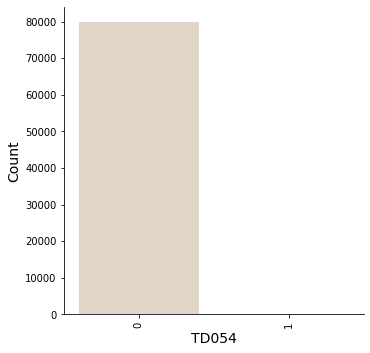

In [10]:
sns.catplot(x=mulna[3], kind="count", palette="ch:.25", data=df)
plt.xticks(rotation=90)
plt.xlabel(mulna[3],fontsize=14,color='black')
plt.ylabel('Count',fontsize=14,color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.show()

In [11]:
df['MB005'].value_counts()

4.0     9837
5.0     9119
3.0     8182
6.0     7831
2.0     6877
7.0     6240
8.0     5271
1.0     5015
9.0     4370
10.0    3975
11.0    2935
12.0    1774
13.0    1705
14.0    1227
0.0     1132
15.0     643
16.0     432
17.0     267
18.0     180
19.0      92
20.0      50
21.0      24
22.0      13
27.0       4
25.0       4
26.0       2
24.0       2
23.0       2
47.0       2
Name: MB005, dtype: int64

In [12]:
cut_bins = np.linspace(0, df['MB005'].max(), 20).tolist()
name = 'MB005'+'_'+'bin'
df[name] = pd.cut(df['MB005'], bins=cut_bins,duplicates='raise')
df[name] = df[name].cat.add_categories('NoValue')

df[name] = df[name].fillna('NoValue')

df.drop(columns=['MB005'],inplace=True)

d_na = pd.DataFrame(df.isna().sum())
d_na['prop'] = d_na.iloc[:,0]/len(df);
d_na[d_na.iloc[:,0] > 0]

,0,prop
TD022,19598,0.244975
TD023,7663,0.095787
TD024,3694,0.046175


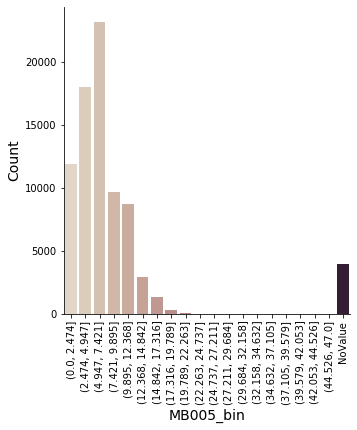

In [13]:
sns.catplot(x="MB005_bin", kind="count", palette="ch:.25", data=df)
plt.xticks(rotation=90)
plt.xlabel('MB005_bin',fontsize=14,color='black')
plt.ylabel('Count',fontsize=14,color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.show()


In [14]:
df[['TD022','TD023','TD024']].describe()

,TD022,TD023,TD024
count,60402.000000,72337.000000,76306.000000
mean,17.120294,7.293156,5.541687
std,7.024737,7.395779,6.157043
min,10.000000,0.000000,0.000000
25%,10.000000,3.000000,2.000000
50%,15.000000,6.000000,4.000000
75%,20.000000,12.000000,8.000000
max,30.000000,30.000000,30.000000


In [15]:
for xx in ['TD022','TD023','TD024']:
    cutpoint = np.linspace(0, df[xx].max(), 30).tolist()
    name = xx + '_' + 'bin'
    df[name] = pd.cut(df[xx], bins=cutpoint,duplicates='raise')
    df[name] = df[name].cat.add_categories('NoValue')

df.drop(columns=['TD022','TD023','TD024'],inplace=True)

df[['TD022_bin','TD023_bin','TD024_bin']] = df[['TD022_bin','TD023_bin','TD024_bin']].fillna('NoValue')

In [16]:
viz = colnames + ['TD022_bin','TD023_bin','TD024_bin']

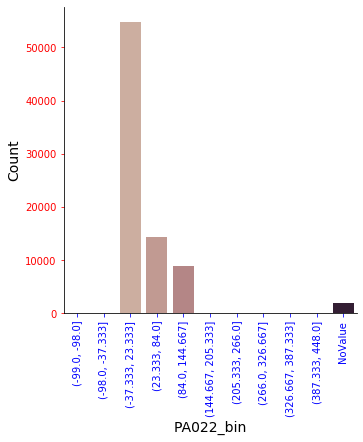

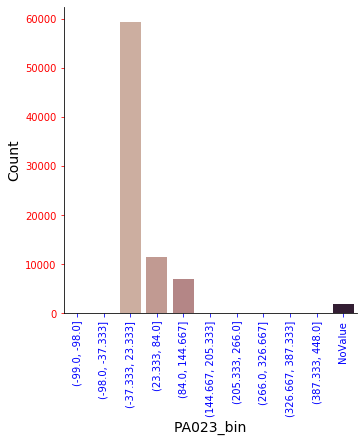

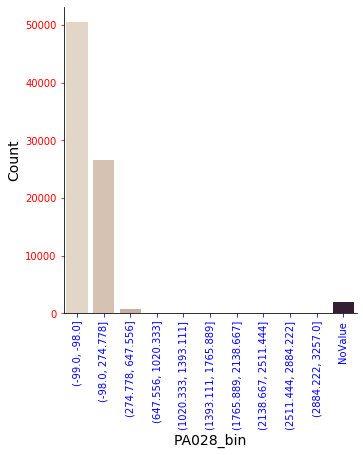

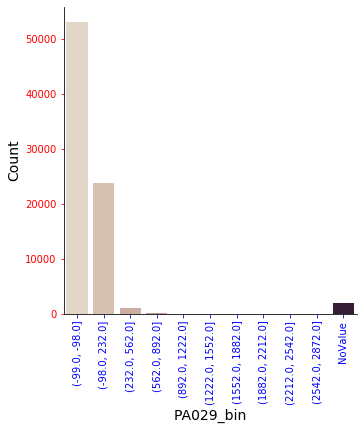

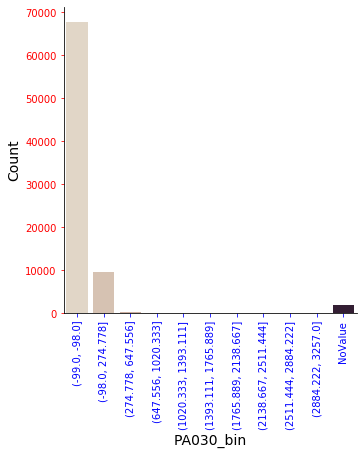

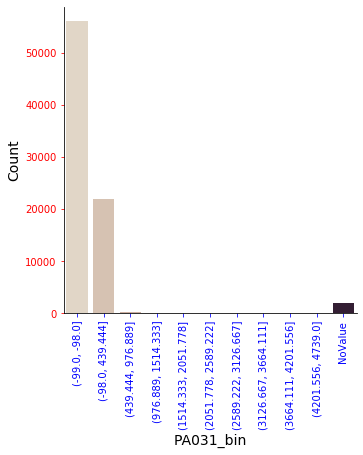

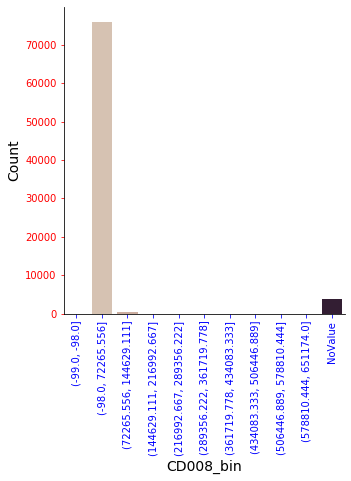

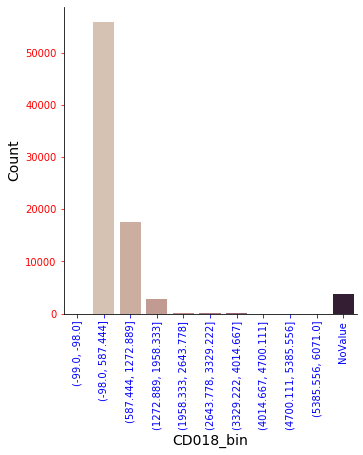

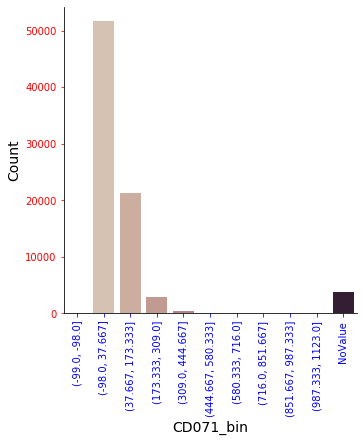

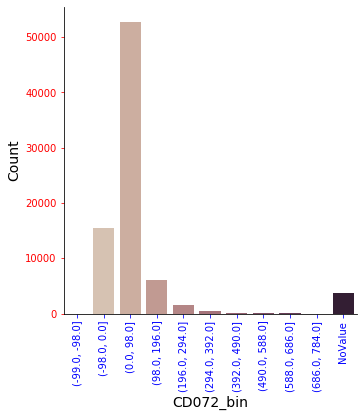

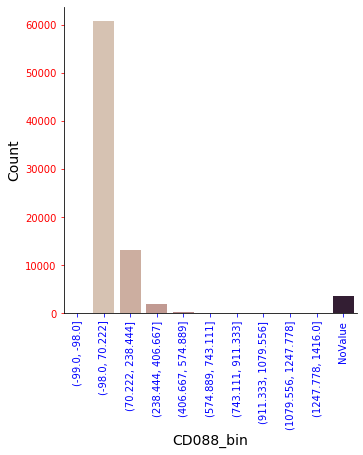

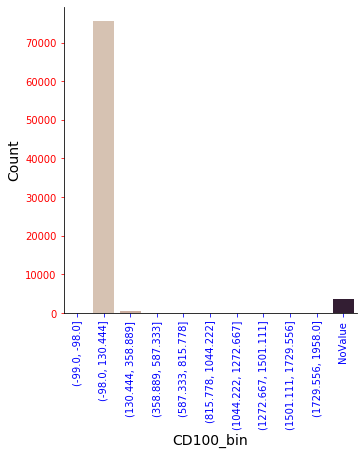

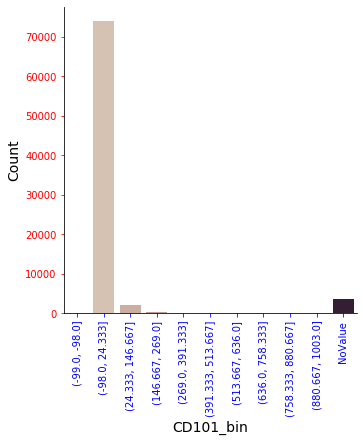

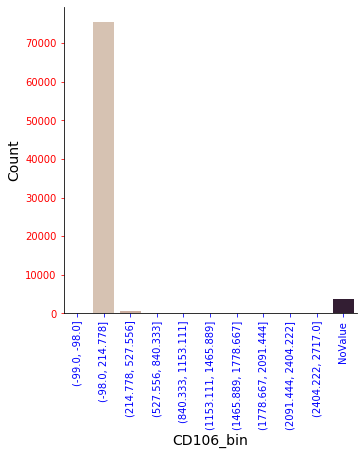

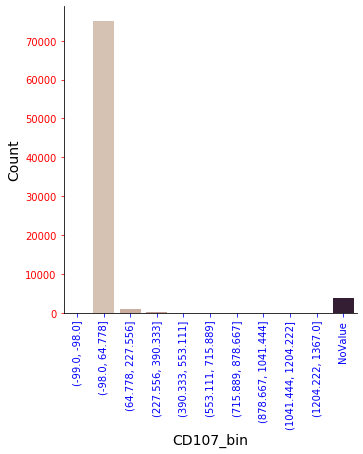

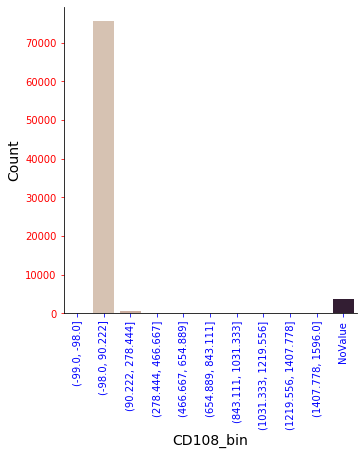

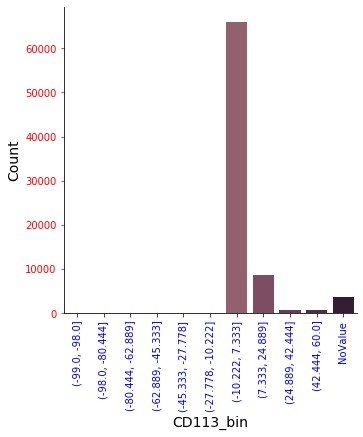

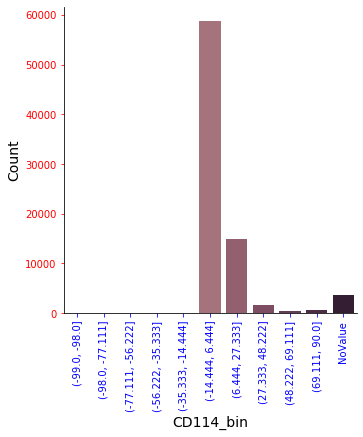

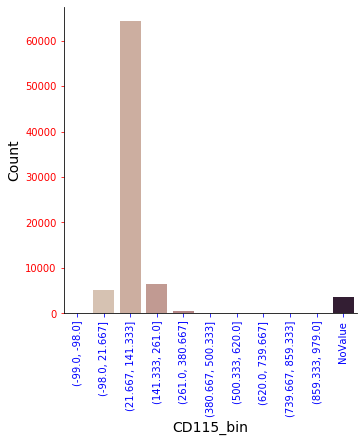

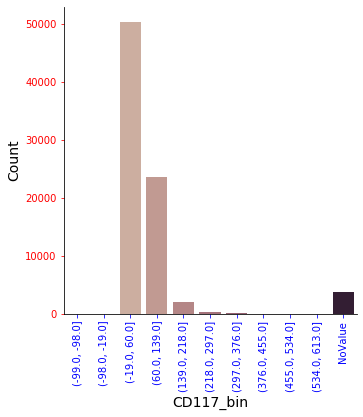

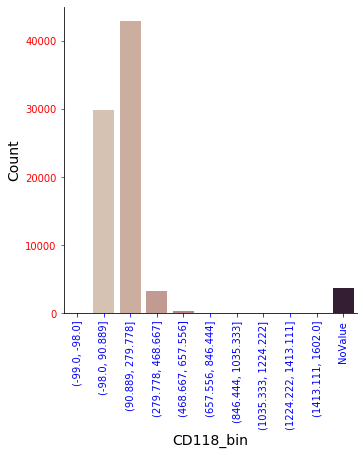

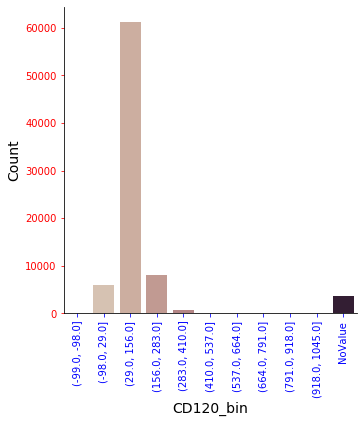

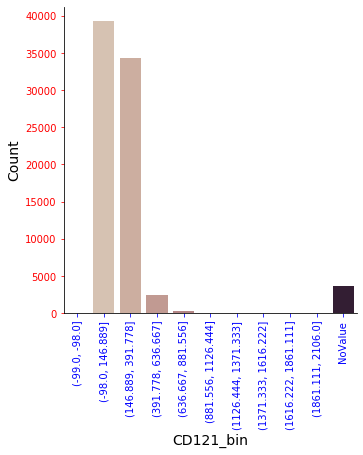

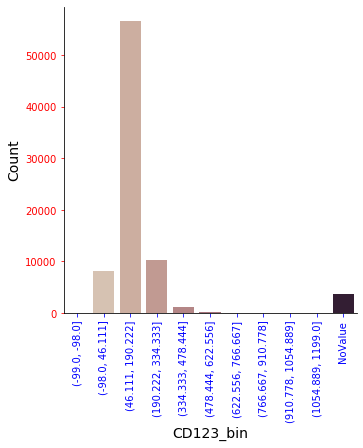

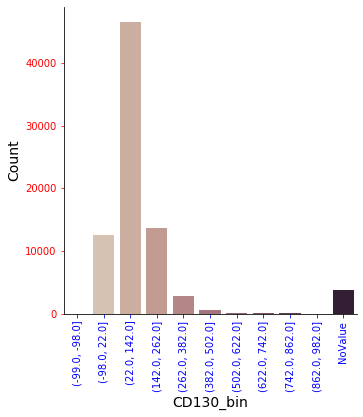

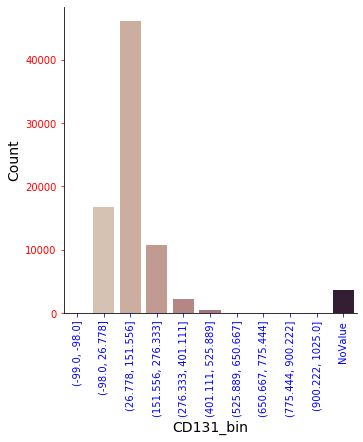

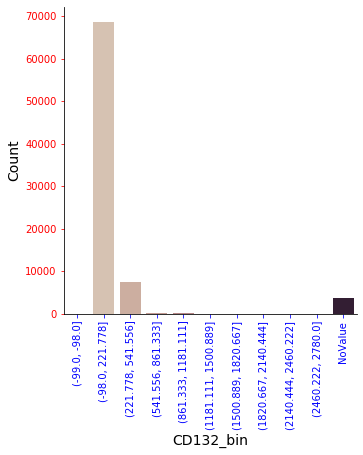

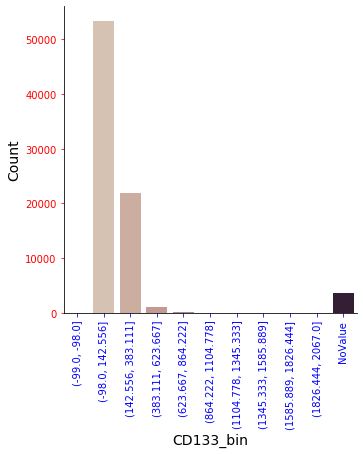

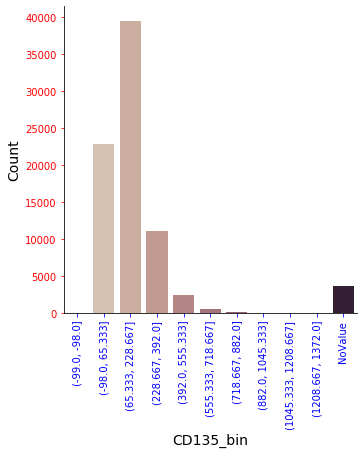

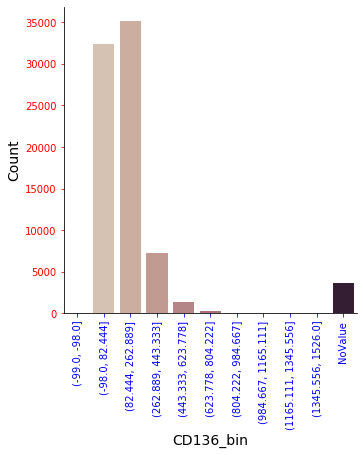

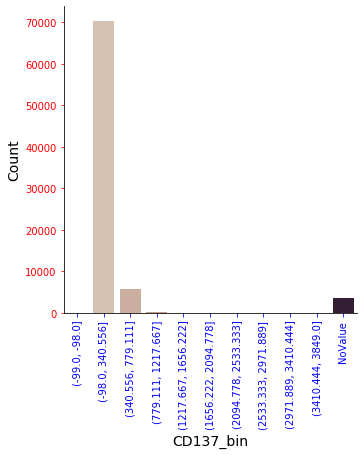

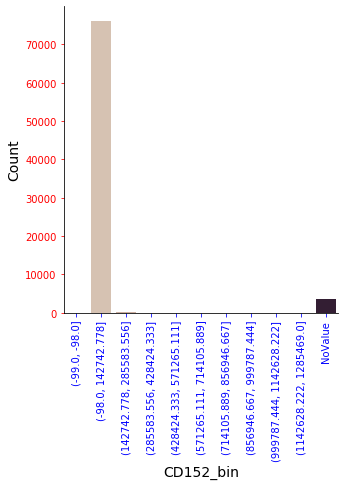

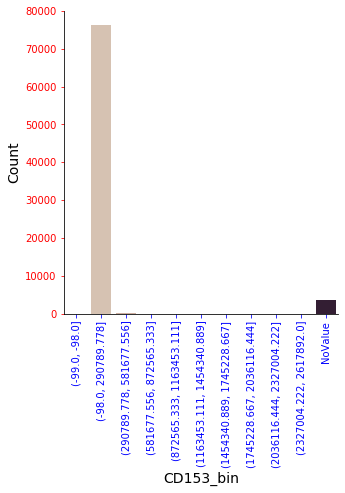

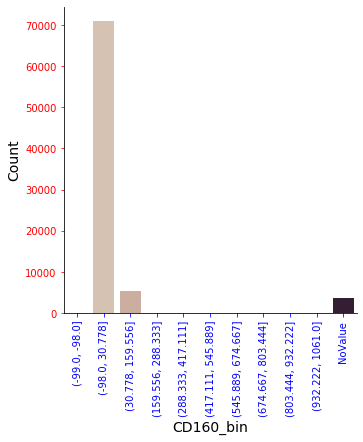

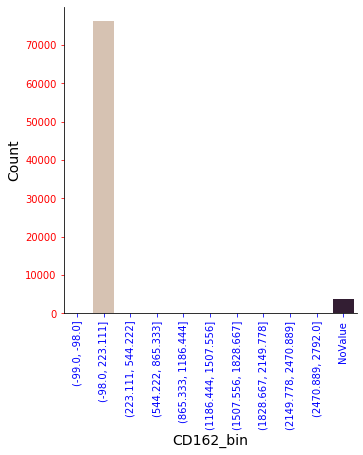

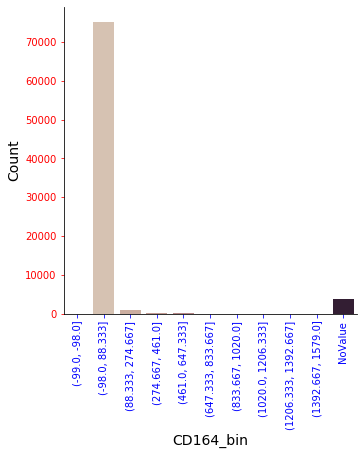

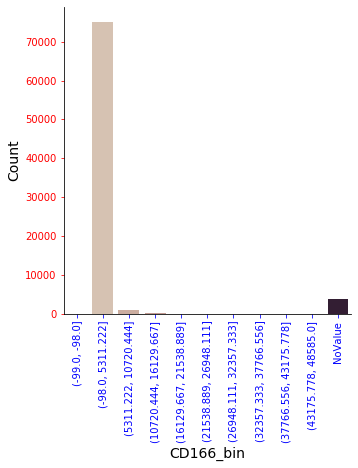

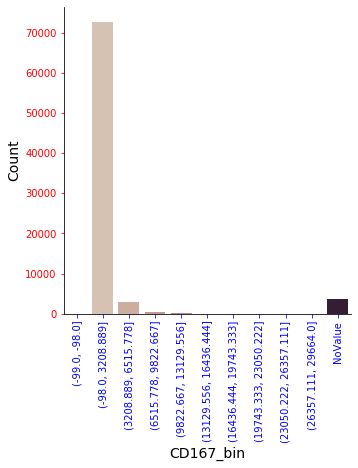

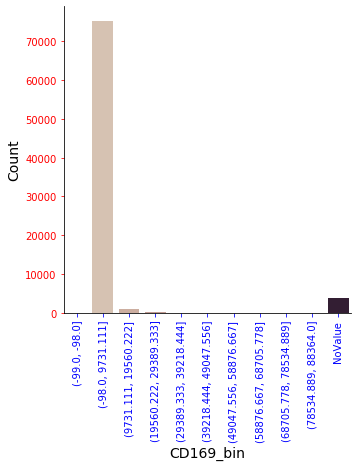

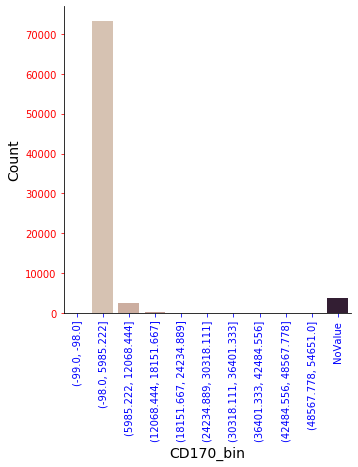

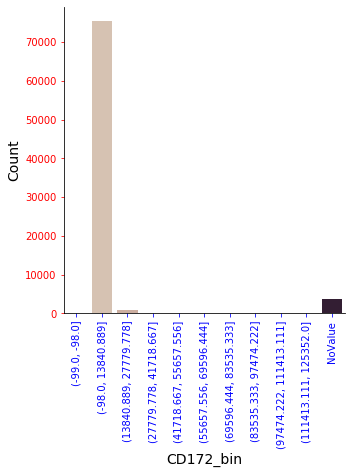

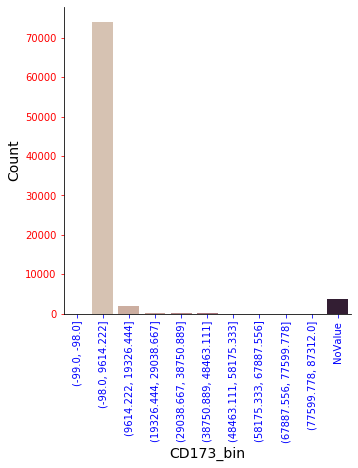

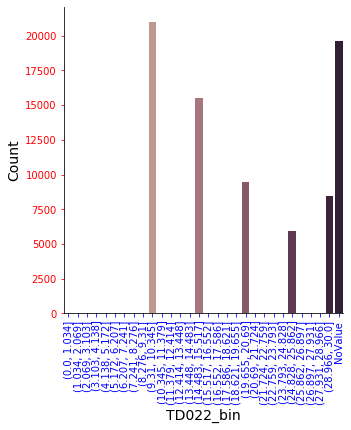

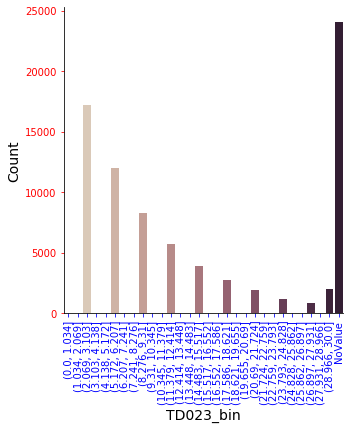

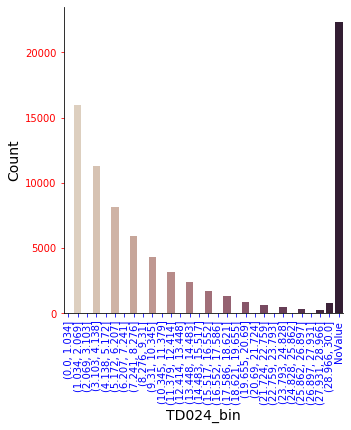

In [17]:
for i in range(len(viz)):
    sns.catplot(x=viz[i], kind="count", palette="ch:.25", data=df)
    plt.xticks(rotation=90)
    plt.xlabel(viz[i],fontsize=14,color='black')
    plt.ylabel('Count',fontsize=14,color='black')
    plt.tick_params(axis='x', colors='blue')
    plt.tick_params(axis='y', colors='red')
    plt.show()


##### Modeling with H2o; GLM

The first model to run will be a GLM model with simple parameters. Lets compare results and understand why the model is producing those results.

In [18]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from sklearn.model_selection import train_test_split
from h2o.automl import H2OAutoML

In [19]:
train, test = train_test_split(
     df.drop(columns='id'), test_size=0.40, random_state=42)

target='loan_default'
predictors = train.columns.tolist()
predictors.remove(target)

In [20]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)
train_hex[target] = train_hex[target].asfactor()
test_hex[target] = test_hex[target].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
train_hex.head()

loan_default,AP001,AP002,AP003,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD044,TD048,TD051,TD054,TD055,TD061,TD062,CR004,CR005,CR009,CR015,CR017,CR018,CR019,MB007,PA022_bin,PA023_bin,PA028_bin,PA029_bin,PA030_bin,PA031_bin,CD008_bin,CD018_bin,CD071_bin,CD072_bin,CD088_bin,CD100_bin,CD101_bin,CD106_bin,CD107_bin,CD108_bin,CD113_bin,CD114_bin,CD115_bin,CD117_bin,CD118_bin,CD120_bin,CD121_bin,CD123_bin,CD130_bin,CD131_bin,CD132_bin,CD133_bin,CD135_bin,CD136_bin,CD137_bin,CD152_bin,CD153_bin,CD160_bin,CD162_bin,CD164_bin,CD166_bin,CD167_bin,CD169_bin,CD170_bin,CD172_bin,CD173_bin,MB005_bin,TD022_bin,TD023_bin,TD024_bin
0,24,1,4,2017-05-03 14:08:00,ios,3,3,1,0,0,1,2,4,4,4,3,1,0,0,0,0,0,0,0,4,3,16100,3,1,1,2,IPHONE7,"(-37.333, 23.333]","(-37.333, 23.333]","(-99.0, -98.0]","(-99.0, -98.0]","(-99.0, -98.0]","(-99.0, -98.0]","(-98.0, 72265.556]","(-98.0, 587.444]","(37.667, 173.333]","(0.0, 98.0]","(70.222, 238.444]","(-98.0, 130.444]","(24.333, 146.667]","(-98.0, 214.778]","(-98.0, 64.778]","(-98.0, 90.222]","(7.333, 24.889]","(27.333, 48.222]","(21.667, 141.333]","(-19.0, 60.0]","(-98.0, 90.889]","(29.0, 156.0]","(-98.0, 146.889]","(46.111, 190.222]","(22.0, 142.0]","(26.778, 151.556]","(-98.0, 221.778]","(-98.0, 142.556]","(65.333, 228.667]","(-98.0, 82.444]","(-98.0, 340.556]","(-98.0, 142742.778]","(-98.0, 290789.778]","(-98.0, 30.778]","(-98.0, 223.111]","(-98.0, 88.333]","(-98.0, 5311.222]","(-98.0, 3208.889]","(-98.0, 9731.111]","(-98.0, 5985.222]","(-98.0, 13840.889]","(-98.0, 9614.222]","(4.947, 7.421]",NoValue,"(5.172, 6.207]","(11.379, 12.414]"
1,26,1,3,2017-06-01 10:49:00,android,5,5,1,4,4,4,6,6,6,6,6,1,0,0,0,0,0,0,0,4,6,54900,2,2,2,4,VIVO,"(-37.333, 23.333]","(-37.333, 23.333]","(-99.0, -98.0]","(-99.0, -98.0]","(-99.0, -98.0]","(-99.0, -98.0]","(-98.0, 72265.556]","(-98.0, 587.444]","(-98.0, 37.667]","(0.0, 98.0]","(-98.0, 70.222]","(-98.0, 130.444]","(-98.0, 24.333]","(-98.0, 214.778]","(-98.0, 64.778]","(-98.0, 90.222]","(-10.222, 7.333]","(-14.444, 6.444]","(21.667, 141.333]","(-19.0, 60.0]","(-98.0, 90.889]","(-98.0, 29.0]","(-98.0, 146.889]","(-98.0, 46.111]","(-98.0, 22.0]","(-98.0, 26.778]","(-98.0, 221.778]","(-98.0, 142.556]","(-98.0, 65.333]","(-98.0, 82.444]","(-98.0, 340.556]","(-98.0, 142742.778]","(-98.0, 290789.778]","(-98.0, 30.778]","(-98.0, 223.111]","(-98.0, 88.333]","(-98.0, 5311.222]","(-98.0, 3208.889]","(-98.0, 9731.111]","(-98.0, 5985.222]","(-98.0, 13840.889]","(-98.0, 9614.222]","(2.474, 4.947]","(28.966, 30.0]","(5.172, 6.207]","(5.172, 6.207]"
1,32,1,1,2017-05-31 13:37:00,h5,5,5,1,3,0,4,1,4,1,6,1,0,0,0,0,0,0,0,0,2,1,0,3,5,4,3,WEB,"(23.333, 84.0]","(23.333, 84.0]","(-98.0, 274.778]","(-98.0, 232.0]","(-99.0, -98.0]","(-98.0, 439.444]","(-98.0, 72265.556]","(587.444, 1272.889]","(173.333, 309.0]","(0.0, 98.0]","(-98.0, 70.222]","(-98.0, 130.444]","(-98.0, 24.333]","(-98.0, 214.778]","(-98.0, 64.778]","(-98.0, 90.222]","(-10.222, 7.333]","(6.444, 27.333]","(21.667, 141.333]","(-19.0, 60.0]","(90.889, 279.778]","(29.0, 156.0]","(146.889, 391.778]","(46.111, 190.222]","(22.0, 142.0]","(151.556, 276.333]","(221.778, 541.556]","(142.556, 383.111]","(65.333, 228.667]","(262.889, 443.333]","(-98.0, 340.556]","(-98.0, 142742.778]","(-98.0, 290789.778]","(30.778, 159.556]","(-98.0, 223.111]","(-98.0, 88.333]","(-98.0, 5311.222]","(-98.0, 3208.889]","(-98.0, 9731.111]","(-98.0, 5985.222]","(-98.0, 13840.889]","(-98.0, 9614.222]","(0.0, 2.474]","(14.483, 15.517]","(5.172, 6.207]",NoValue
0,49,2,3,2017-06-20 13:36:00,ios,5,3,0,2,0,8,7,9,9,10,9,1,0,0,0,0,0,0,0,4,5,220000,6,7,7,10,IPHONE6,"(23.333, 84.0]","(-37.333, 23.333]","(-98.0, 274.778]","(-99.0, -98.0]","(-98.0, 274.778]","(-99.0, -98.0]","(-98.0, 72265.556]","(-98.0, 587.444]","(-98.0, 37.667]","(0.0, 98.0]","(-98.0, 70.222]","(-98.0, 130.444]","(-98.0, 24.333]","(-98.0, 214.778]","(-98.0, 64.778]","(-98.0, 90.222]","(-10.222, 7.333]","(-14.444, 6.444]","(21.667, 141.333]","(-19.0, 60.0]","(-98.0, 90.889]","(2

In [22]:
glm_v1 = H2OGeneralizedLinearEstimator(family= "binomial", lambda_ = 0.05) #, compute_p_values = True)
glm_v1.train(predictors,target,training_frame=train_hex,validation_frame = test_hex)

glm_v1.predict(test_hex)

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


/Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: [4G, HASEE, HTC, IPAD4, IVVI, KINGSUN, PROTRULY, SMARTISAN, YEPEN]
  warnings.warn(w)
/Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'MB005_bin' has levels not trained on: [(24.737, 27.211]]
  warnings.warn(w)
/Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'CD121_bin' has levels not trained on: [(1126.444, 1371.333]]
  warnings.warn(w)
/Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'CD107_bin' has levels not trained on: [(715.889, 878.667]]
  warnings.warn(w)
/Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'CD173_bin' has levels not trained on

predict,p0,p1
1,0.797385,0.202615
1,0.806457,0.193543
0,0.82972,0.17028
0,0.830834,0.169166
0,0.831598,0.168402
1,0.795778,0.204222
0,0.828389,0.171611
1,0.780149,0.219851
0,0.82988,0.17012
0,0.844644,0.155356


In [23]:
glm_v1.predict(test_hex)['p1']

glm prediction progress: |████████████████████████████████████████████████| 100%


p1
0.202615
0.193543
0.17028
0.169166
0.168402
0.204222
0.171611
0.219851
0.17012
0.155356


The first model seems to show good results on the non-default values. Here we can the predicted value vs the real value. If the predicted value (p1) is below 0.5 then its predicted as 0, if higher then its predicted as 1.

In [24]:
predictions = glm_v1.predict(test_hex)['p1']
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

glm prediction progress: |████████████████████████████████████████████████| 100%


,loan_default,p1
0,0,0.202615
1,0,0.193543
2,0,0.170280
3,0,0.169166
4,0,0.168402


In [25]:
def createGains(model):
    predictions = model.predict(test_hex)['p1']
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='p1',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(glm_v1)


glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,101,219,320,101,219,0.17,0.08,60.0,1.68,9.0,31.56
1,320,61,259,640,162,478,0.27,0.18,120.0,1.35,9.0,25.31
2,320,80,240,960,242,718,0.40,0.28,180.0,1.34,12.0,25.21
3,320,77,243,1280,319,961,0.53,0.37,240.0,1.33,16.0,24.92
4,320,54,266,1600,373,1227,0.62,0.47,300.0,1.24,15.0,23.31
5,320,58,262,1920,431,1489,0.72,0.57,360.0,1.20,15.0,22.45
6,320,46,274,2240,477,1763,0.80,0.68,420.0,1.14,12.0,21.29
7,320,51,269,2560,528,2032,0.88,0.78,480.0,1.10,10.0,20.62
8,320,39,281,2880,567,2313,0.94,0.89,540.0,1.05,5.0,19.69


##### Gains Table

The gains table shows some healthy lift of 1.68 on the first decile. Some more work could be done. Lets look at the ROC auc curve too to grasp the accuracy of the model.

glm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



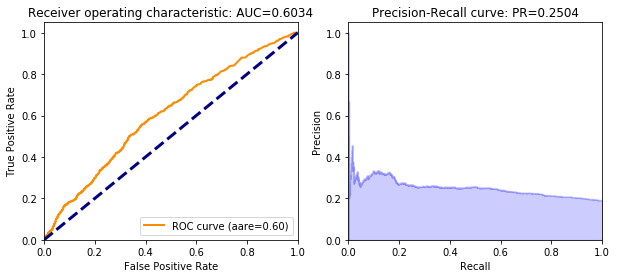

In [26]:
def ROC_AUC(my_result, df, target):
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df)['p1'].as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr, tpr, _ = roc_curve(y_actual, y_pred)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall
    average_precision = average_precision_score(y_actual, y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print(
        '	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print(
        '   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')

    # plotting
    plt.figure(figsize=(10, 4))

    # ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_actual, y_pred)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

ROC_AUC(glm_v1,test_hex,'loan_default')

##### Variable Importance

Something is not right here. It seems that only three variables have any impact on the model and that the rest have nothing to add to the model. This is a clear indication that some more parameter tuning is needed.

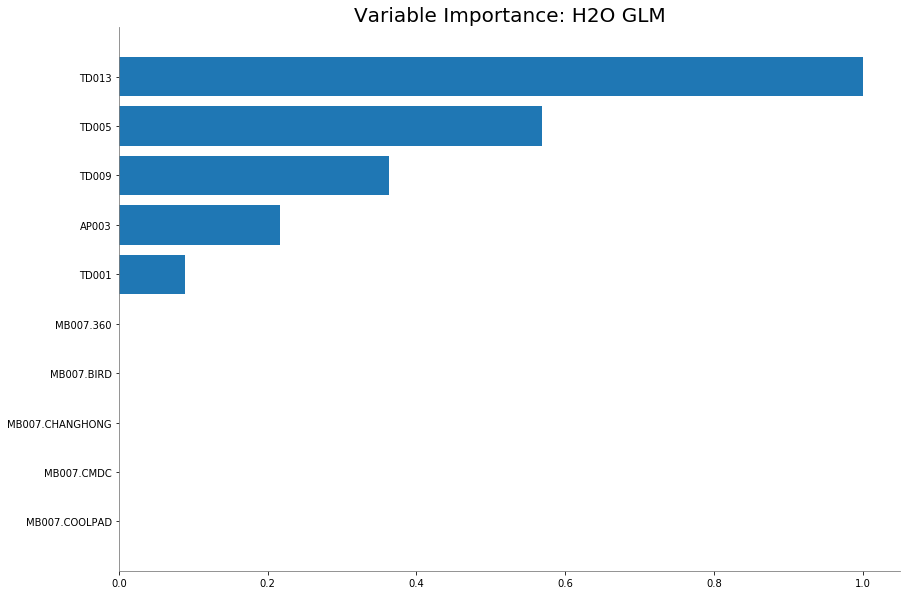

In [27]:
glm_v1.varimp_plot()

In [28]:
glm_v1.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18448350463109459: 


,,0,1,Error,Rate
0,0,2333.0,1565.0,0.4015,(1565.0/3898.0)
1,1,373.0,529.0,0.4135,(373.0/902.0)
2,Total,2706.0,2094.0,0.4037,(1938.0/4800.0)


##### Second Model

Although the first model produced somewhat decent results the variable importance plot shows us that the model needs work. A way to do this is to use the cross validation method withing the glm algorithm in H2o. By setting the number of nfolds and the lambda_search parameter to True then the algorithm is going to iterate over several modules with different parameters until it finds the ideal one.

In [29]:
glm_v2 = H2OGeneralizedLinearEstimator(family= "binomial", lambda_search= True,fold_assignment = 'Modulo',
                                       keep_cross_validation_fold_assignment = True,nfolds=10,seed = 123,model_id = "glm_tuned")
glm_v2.train(predictors,target,training_frame=train_hex,validation_frame = test_hex)
glm_v2.predict(test_hex)

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.767133,0.232867
0,0.845768,0.154232
0,0.898852,0.101148
0,0.826286,0.173714
0,0.845872,0.154128
1,0.772291,0.227709
0,0.828193,0.171807
1,0.705615,0.294385
0,0.825796,0.174204
0,0.854502,0.145498


In [30]:
glm_v2.predict(test_hex)['p1']

glm prediction progress: |████████████████████████████████████████████████| 100%


p1
0.232867
0.154232
0.101148
0.173714
0.154128
0.227709
0.171807
0.294385
0.174204
0.145498


This clearly shows that this model is able to grasp much more information from the dataset and therefore produced better results. The auc has gone up too. Lets look at a gains table then to see if the model is really making an impact.

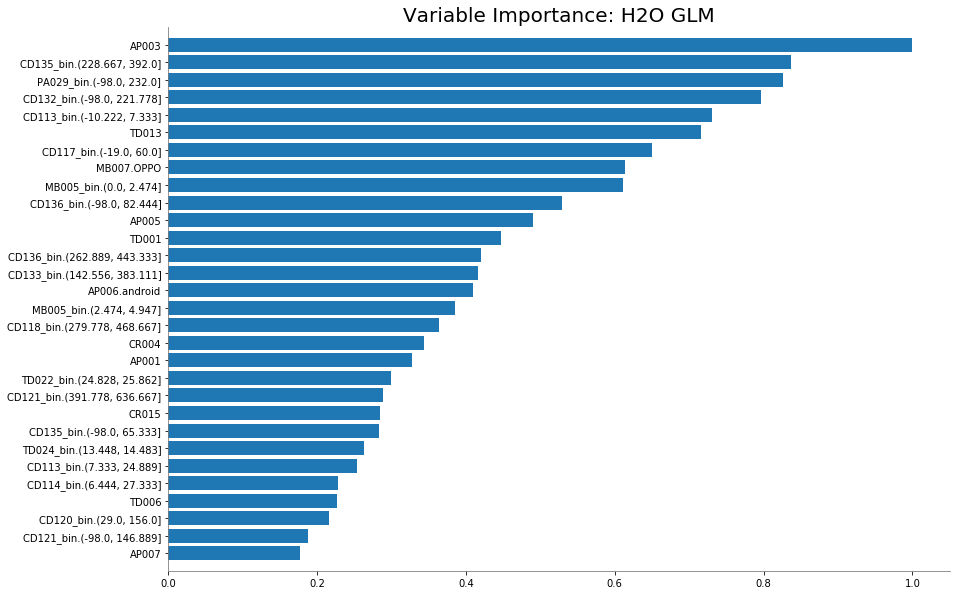

In [31]:
glm_v2.varimp_plot(30)

In [32]:
glm_v2.auc()

0.6777271646497892

##### Gains Table

The gains table shows a better lift than the original model. Combining the auc and the lift of the model we can say then that the glm_v2 is objectively a better model than the glm_v1. Now lets use autoML to see if we can get better results.

In [33]:
createGains(glm_v2)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,112,208,320,112,208,0.19,0.08,60.0,1.87,11.0,35.00
1,320,82,238,640,194,446,0.32,0.17,120.0,1.62,15.0,30.31
2,320,89,231,960,283,677,0.47,0.26,180.0,1.57,21.0,29.48
3,320,69,251,1280,352,928,0.59,0.36,240.0,1.47,23.0,27.50
4,320,58,262,1600,410,1190,0.68,0.46,300.0,1.37,22.0,25.62
5,320,60,260,1920,470,1450,0.78,0.56,360.0,1.31,22.0,24.48
6,320,46,274,2240,516,1724,0.86,0.66,420.0,1.23,20.0,23.04
7,320,32,288,2560,548,2012,0.91,0.77,480.0,1.14,14.0,21.41
8,320,37,283,2880,585,2295,0.98,0.88,540.0,1.08,10.0,20.31


##### AutoML

The automl algorithm in H2o iterates over several glm models and different versions of the glm model like XGBoost to find the best module. In this case I'll let the algorithm run for about 3 minutes and see what's the best model it can come up with.

In [34]:
aml_v1 = H2OAutoML(max_runtime_secs = 200, max_models=100, seed=123)
aml_v1.train(predictors,target,training_frame=train_hex,validation_frame = test_hex)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [35]:
aml_v1.leaderboard.head()

model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_1_AutoML_20191130_165534_model_1,0.644581,0.463367,0.391573,0.382897,0.14661
StackedEnsemble_BestOfFamily_AutoML_20191130_165534,0.644409,0.464621,0.38597,0.383263,0.14689
StackedEnsemble_AllModels_AutoML_20191130_165534,0.642181,0.465408,0.386869,0.383705,0.147229
XGBoost_3_AutoML_20191130_165534,0.634365,0.466794,0.399993,0.384639,0.147947
XGBoost_grid_1_AutoML_20191130_165534_model_6,0.6309,0.467702,0.404591,0.384946,0.148183
XGBoost_grid_1_AutoML_20191130_165534_model_7,0.63079,0.467911,0.405779,0.385036,0.148253
XGBoost_1_AutoML_20191130_165534,0.625754,0.470654,0.408147,0.38635,0.149266
XGBoost_grid_1_AutoML_20191130_165534_model_2,0.624928,0.469314,0.411546,0.385303,0.148459
XGBoost_grid_1_AutoML_20191130_165534_model_3,0.623903,0.469841,0.403145,0.385665,0.148737
XGBoost_2_AutoML_20191130_165534,0.622981,0.470595,0.408271,0.385976,0.148977


In [36]:
pred = aml_v1.predict(test_hex)
pred.head()


glm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.774058,0.225942
0,0.857289,0.142711
0,0.903426,0.0965742
0,0.830178,0.169822
0,0.849453,0.150547
1,0.794947,0.205053
1,0.799983,0.200017
1,0.68474,0.31526
0,0.835335,0.164665
0,0.851153,0.148847


The model is perfroming decently and better than the glm_v1, yet it is not able to beat the glm_v2 tuned model. This might be due to the time constraints but it seems that glm_v2 is the winner.

In [37]:
perf = aml_v1.leader.model_performance(test_hex)
perf


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.14534055427130246
RMSE: 0.3812355627053993
LogLoss: 0.4583100883218124
Null degrees of freedom: 3199
Residual degrees of freedom: 2823
Null deviance: 3088.50005970821
Residual deviance: 2933.184565259599
AIC: 3687.184565259599
AUC: 0.6631698717948717
pr_auc: 0.28963091741202784
Gini: 0.3263397435897435

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18901668153812964: 


,,0,1,Error,Rate
0,0,1569.0,1031.0,0.3965,(1031.0/2600.0)
1,1,215.0,385.0,0.3583,(215.0/600.0)
2,Total,1784.0,1416.0,0.3894,(1246.0/3200.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.189017,0.381944,225.0
1,max f2,0.127099,0.562975,314.0
2,max f0point5,0.218340,0.326567,187.0
3,max accuracy,0.647097,0.812500,1.0
4,max precision,0.647097,0.500000,1.0
5,max recall,0.078147,1.000000,374.0
6,max specificity,0.719139,0.999615,0.0
7,max absolute_mcc,0.210872,0.197864,197.0
8,max min_per_class_accuracy,0.192108,0.618462,221.0
9,max mean_per_class_accuracy,0.189017,0.622564,225.0



Gains/Lift Table: Avg response rate: 18.75 %, avg score: 19.17 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.474546,2.000000,2.000000,0.375000,0.532809,0.375000,0.532809,0.020000,0.020000,100.000000,100.000000
1,,2,0.02,0.417553,2.833333,2.416667,0.531250,0.450765,0.453125,0.491787,0.028333,0.048333,183.333333,141.666667
2,,3,0.03,0.382569,1.833333,2.222222,0.343750,0.400471,0.416667,0.461349,0.018333,0.066667,83.333333,122.222222
3,,4,0.04,0.362685,1.333333,2.000000,0.250000,0.372284,0.375000,0.439082,0.013333,0.080000,33.333333,100.000000
4,,5,0.05,0.346075,1.500000,1.900000,0.281250,0.354983,0.356250,0.422263,0.015000,0.095000,50.000000,90.000000
5,,6,0.10,0.301891,1.666667,1.783333,0.312500,0.319765,0.334375,0.371014,0.083333,0.178333,66.666667,78.333333
6,,7,0.15,0.276001,1.633333,1.733333,0.306250,0.288215,0.325000,0.343414,0.081667,0.260000,63.333333,73.333333
7,,8,0.20,0.253914,1.200000,1.600000,0.225000,0.264066,0.300000,0.323577,0.060000,0.320000,20.000000,60.000000
8,,9,0.30,0.220220,1.583333,1.594444,0.296875,0.236778,0.298958,0.294644,0.158333,0.478333,58.333333,59.444444
9,,10,0.40,0.196746,1.100000,1.470833,0.206250,0.207935,0.275781,0.272967,0.110000,0.588333,10.000000,47.083333


In [38]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(aml_v1)

glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,96,224,320,96,224,0.16,0.09,60.0,1.60,7.0,30.00
1,320,93,227,640,189,451,0.32,0.17,120.0,1.58,15.0,29.53
2,320,85,235,960,274,686,0.46,0.26,180.0,1.52,20.0,28.54
3,320,80,240,1280,354,926,0.59,0.36,240.0,1.48,23.0,27.66
4,320,59,261,1600,413,1187,0.69,0.46,300.0,1.38,23.0,25.81
5,320,37,283,1920,450,1470,0.75,0.57,360.0,1.25,18.0,23.44
6,320,38,282,2240,488,1752,0.81,0.67,420.0,1.16,14.0,21.79
7,320,42,278,2560,530,2030,0.88,0.78,480.0,1.10,10.0,20.70
8,320,41,279,2880,571,2309,0.95,0.89,540.0,1.06,6.0,19.83


##### Model Ensemble

A way to enhance results of the model is to ensemble all this models into one model and see if results improve.

In [39]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml_v1.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

In [40]:
metalearner.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1668456044917929: 


,,0,1,Error,Rate
0,0,2142.0,1756.0,0.4505,(1756.0/3898.0)
1,1,294.0,608.0,0.3259,(294.0/902.0)
2,Total,2436.0,2364.0,0.4271,(2050.0/4800.0)


In [41]:
metalearner.auc()

0.6474775568572888

In [42]:
createGains(metalearner)

glm prediction progress: |████████████████████████████████████████████████| 100%


/Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column 'GLM_grid_1_AutoML_20191130_165534_model_1': substituting in a column of NaN
  warnings.warn(w)
/Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column 'XGBoost_3_AutoML_20191130_165534': substituting in a column of NaN
  warnings.warn(w)
/Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column 'XGBoost_grid_1_AutoML_20191130_165534_model_6': substituting in a column of NaN
  warnings.warn(w)
/Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column 'XGBoost_grid_1_AutoML_20191130_165534_model_7': substituting in a column of NaN
  warnings.warn(w)
/Users/luislosada/Library/Python/3.6/lib/python/site-packages/h2o/job.py:70: UserWarning:

,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,68,252,320,68,252,0.11,0.1,60.0,1.13,1.0,21.25
1,320,54,266,640,122,518,0.20,0.2,120.0,1.02,0.0,19.06
2,320,56,264,960,178,782,0.30,0.3,180.0,0.99,0.0,18.54
3,320,64,256,1280,242,1038,0.40,0.4,240.0,1.01,0.0,18.91
4,320,58,262,1600,300,1300,0.50,0.5,300.0,1.00,0.0,18.75
5,320,56,264,1920,356,1564,0.59,0.6,360.0,0.99,1.0,18.54
6,320,57,263,2240,413,1827,0.69,0.7,420.0,0.98,1.0,18.44
7,320,64,256,2560,477,2083,0.80,0.8,480.0,0.99,0.0,18.63
8,320,61,259,2880,538,2342,0.90,0.9,540.0,1.00,0.0,18.68


##### Conclusions

Results did not improve and the lift suffered a hit with this ensembled method. It seems that the best glm model for this dataset is the one fine tuned by the cros validation and lambda search. Comparing the results of this model to the ones produced last week by the GBM and RandomForest I could conclude that some feature engineering is needed to get this glm model to perform as good as those algorithms but this could be the benchmark to compare other models to.



In [43]:
df.to_csv('XYZloans_modified.csv')